In [9]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [10]:
RANDOM_STATE = 42

In [11]:
X, y = fetch_openml('mnist_784', return_X_y=True, as_frame=False)
X = X.astype(np.float32) / 255.0           # normalize pixels to [0,1]
y = y.astype(int)                          # ensure integer labels 0..9 (may still be Series)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)


In [13]:
# 🔧 Robustness: ensure arrays (avoids pandas index alignment surprises)
y_train = np.asarray(y_train)
y_test  = np.asarray(y_test)

In [14]:
models = {
    "LogisticRegression": LogisticRegression(
        solver="saga", max_iter=1000, random_state=RANDOM_STATE   # higher max_iter to avoid convergence warning
    ),
    "LinearSVM": LinearSVC(random_state=RANDOM_STATE, max_iter=10000, dual="auto"),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
}

In [15]:
# Try to add XGBoost
try:
    from xgboost import XGBClassifier
    models["XGBoost"] = XGBClassifier(
        objective="multi:softmax",
        num_class=10,
        n_estimators=200,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbosity=0,
    )
except Exception:
    print("XGBoost not available. To install: pip install xgboost")
    print("Proceeding without XGBoost...")

In [16]:
# -------------------------
# 3) Train, Evaluate, Store
# -------------------------
summary_rows = []
reports_text = {}
preds = {}
conf_mats = {}
misclassified_samples = {}  # (idx, y_true_subset, y_pred_subset)
train_times = {}

for name, clf in models.items():
    print(f"\n=== Training {name} ===")
    t0 = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - t0
    train_times[name] = train_time

    y_pred = clf.predict(X_test)
    preds[name] = y_pred

    # Metrics
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
    f1   = f1_score(y_test, y_pred, average="macro", zero_division=0)

    summary_rows.append({
        "Model": name,
        "Accuracy": acc,
        "Precision(macro)": prec,
        "Recall(macro)": rec,
        "F1(macro)": f1,
        "Train_Time_s": train_time
    })

    rpt = classification_report(y_test, y_pred, digits=4)
    reports_text[name] = rpt
    print(rpt)

    cm = confusion_matrix(y_test, y_pred, labels=np.arange(10))
    conf_mats[name] = cm

    # Misclassified (first 9 for a compact 3x3 grid)
    mis_idx = np.flatnonzero(y_pred != y_test)
    take = mis_idx[:9]
    misclassified_samples[name] = (take, y_test[take], y_pred[take])
    print(f"Train time: {train_time:.2f}s | Accuracy: {acc:.4f} | Misclassified shown: {len(take)}")



=== Training LogisticRegression ===


C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0     0.9464    0.9710    0.9585      2071
           1     0.9540    0.9738    0.9638      2363
           2     0.9127    0.9027    0.9077      2097
           3     0.8939    0.8894    0.8916      2142
           4     0.9244    0.9140    0.9192      2047
           5     0.8830    0.8685    0.8757      1894
           6     0.9430    0.9544    0.9487      2063
           7     0.9324    0.9388    0.9355      2188
           8     0.8941    0.8735    0.8837      2048
           9     0.8980    0.8946    0.8963      2087

    accuracy                         0.9193     21000
   macro avg     0.9182    0.9181    0.9181     21000
weighted avg     0.9190    0.9193    0.9191     21000

Train time: 5913.76s | Accuracy: 0.9193 | Misclassified shown: 9

=== Training LinearSVM ===
              precision    recall  f1-score   support

           0     0.9379    0.9768    0.9570      2071
           1     0.9486    0.9687    0.


=== Summary (sorted by Accuracy) ===
                Model  Accuracy  Precision(macro)  Recall(macro)  F1(macro)  \
0             XGBoost  0.974524          0.974414       0.974302   0.974341   
1        RandomForest  0.966571          0.966367       0.966274   0.966300   
2  LogisticRegression  0.919286          0.918185       0.918073   0.918074   
3           LinearSVM  0.911667          0.910415       0.910392   0.910285   
4        DecisionTree  0.865524          0.863986       0.863665   0.863787   

   Train_Time_s  
0    763.390813  
1     37.436820  
2   5913.759011  
3     68.944656  
4     60.185183  


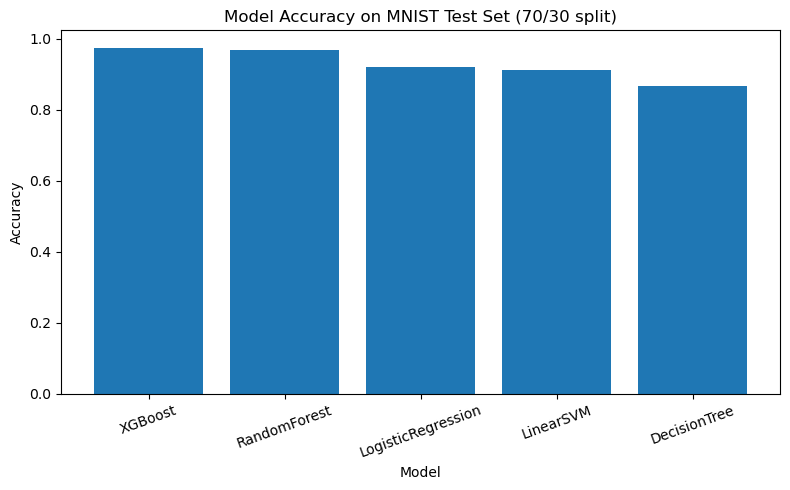

In [18]:
# -------------------------
# 4) Summary Table + Bar Chart
# -------------------------
summary_df = pd.DataFrame(summary_rows).sort_values("Accuracy", ascending=False).reset_index(drop=True)
print("\n=== Summary (sorted by Accuracy) ===")
print(summary_df)

plt.figure(figsize=(8,5))
plt.bar(summary_df["Model"], summary_df["Accuracy"])
plt.title("Model Accuracy on MNIST Test Set (70/30 split)")
plt.xlabel("Model"); plt.ylabel("Accuracy")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

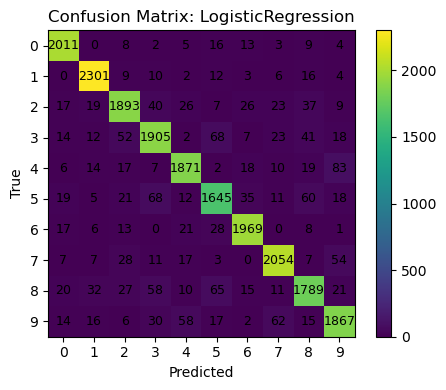

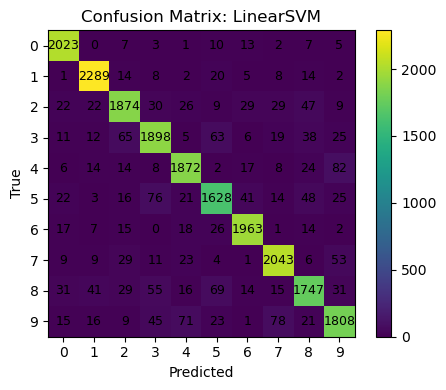

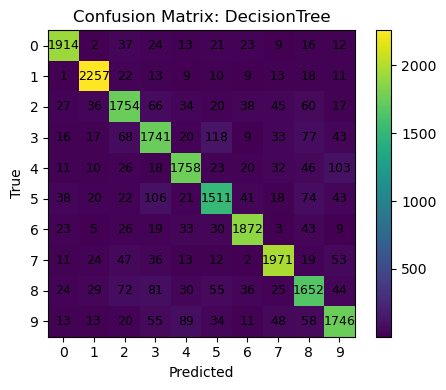

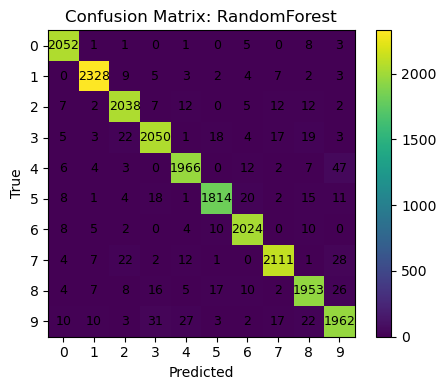

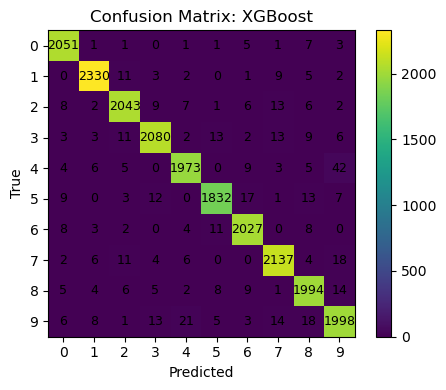

In [19]:
# -------------------------
# 5) Confusion Matrices (one figure per model)
# -------------------------
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted"); plt.ylabel("True")
    ticks = np.arange(10)
    plt.xticks(ticks, ticks)
    plt.yticks(ticks, ticks)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center", fontsize=9)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

for name, cm in conf_mats.items():
    plot_confusion_matrix(cm, name)

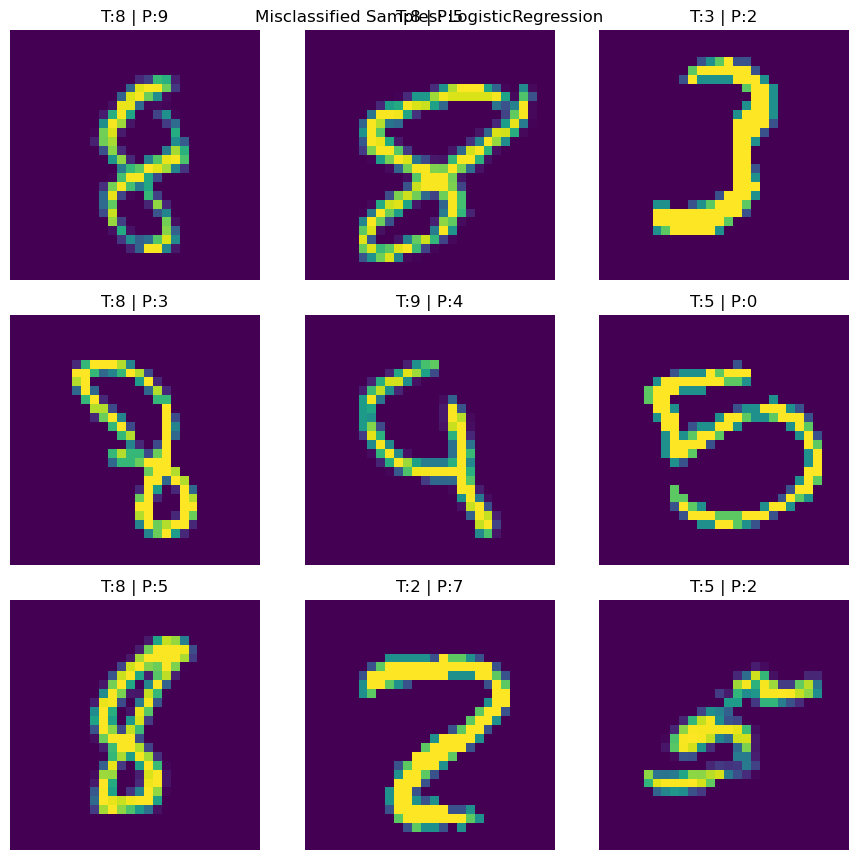

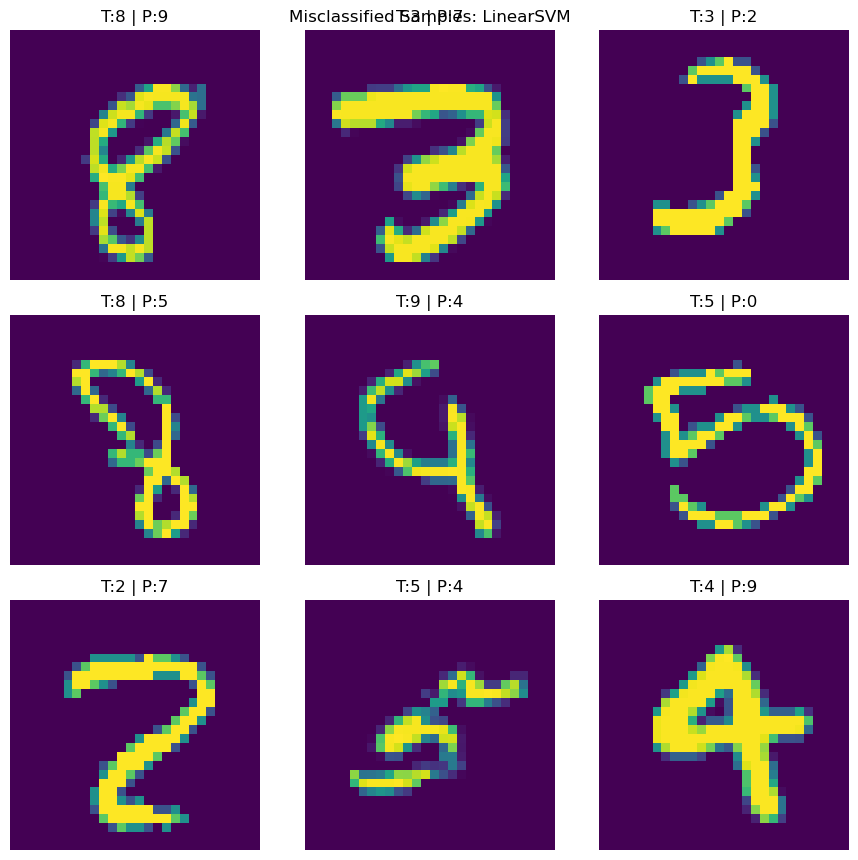

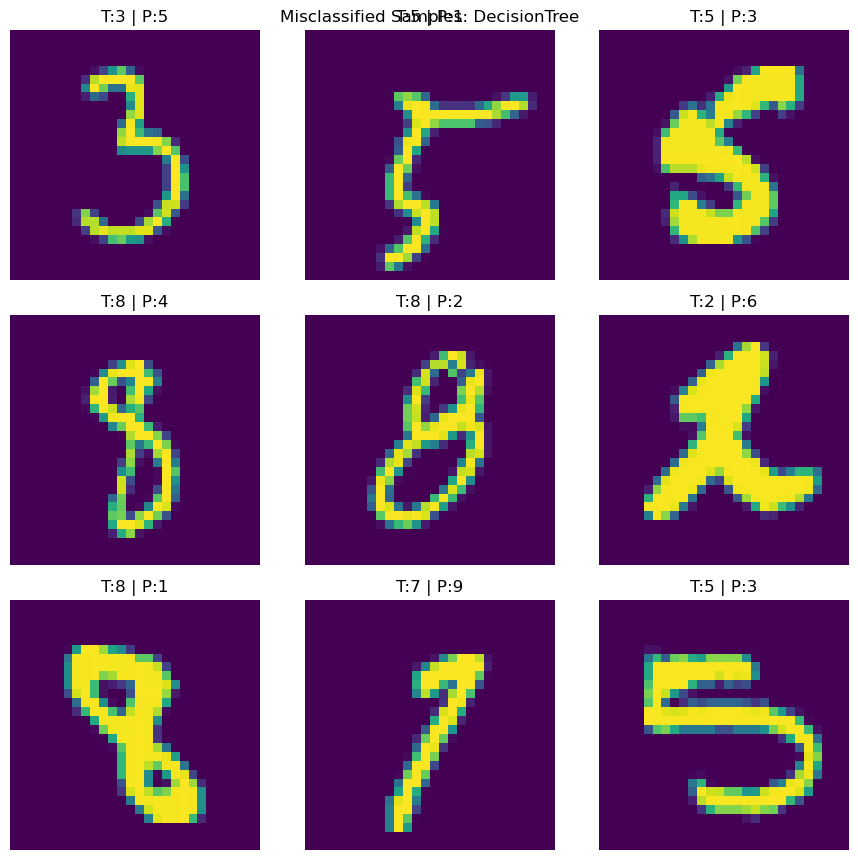

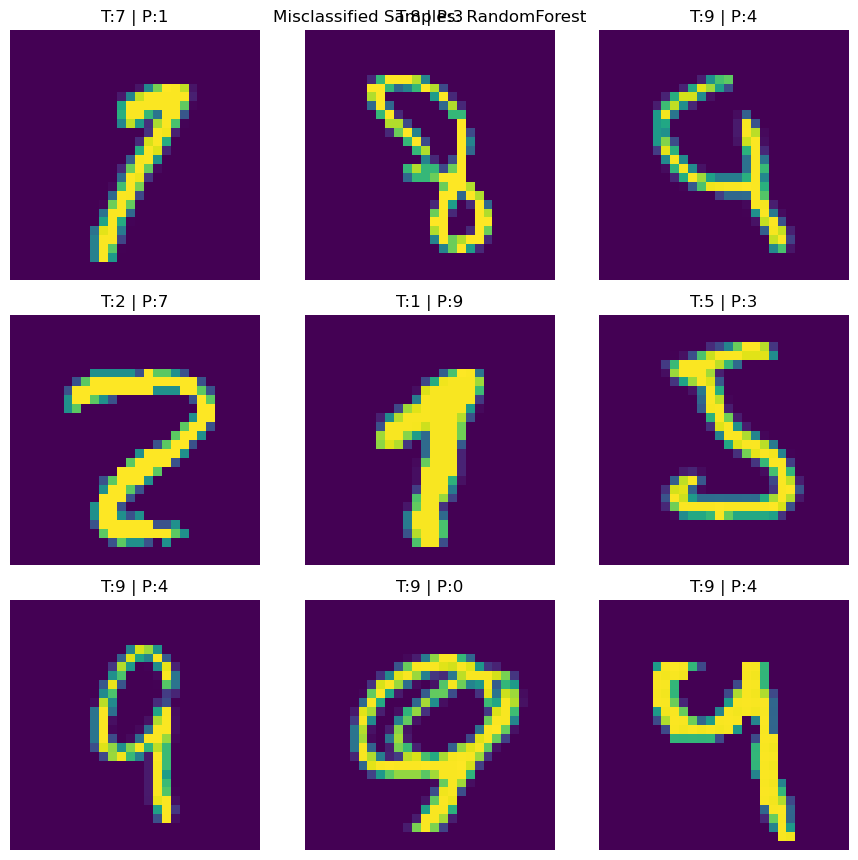

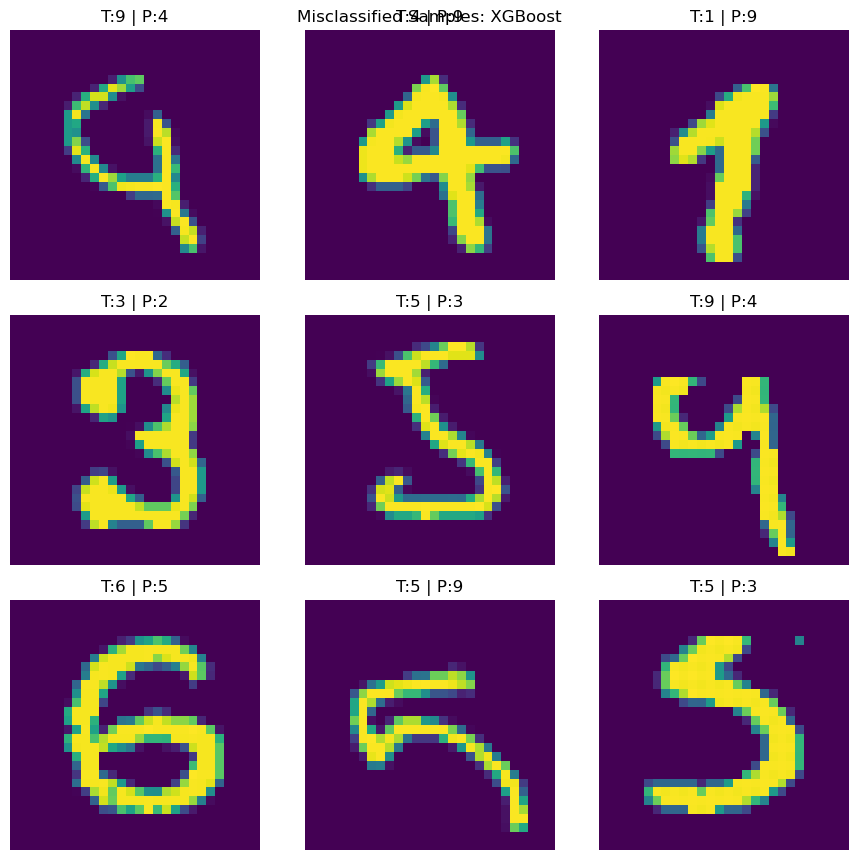

In [20]:
# -------------------------
# 6) Misclassified Samples (9 per model)
# -------------------------
def show_misclassified(name, idxs, y_true_sub, y_pred_sub):
    if len(idxs) == 0:
        print(f"No misclassifications found for {name}.")
        return
    n = len(idxs)
    cols = 3
    rows = int(np.ceil(n/cols))
    plt.figure(figsize=(cols*3, rows*3))
    for i, idx in enumerate(idxs):
        ax = plt.subplot(rows, cols, i+1)
        img = X_test[idx].reshape(28, 28)
        ax.imshow(img)
        ax.set_title(f"T:{y_true_sub[i]} | P:{y_pred_sub[i]}")
        ax.axis("off")
    plt.suptitle(f"Misclassified Samples: {name}", y=0.95)
    plt.tight_layout()
    plt.show()

for name, (idxs, yt_sub, yp_sub) in misclassified_samples.items():
    show_misclassified(name, idxs, yt_sub, yp_sub)


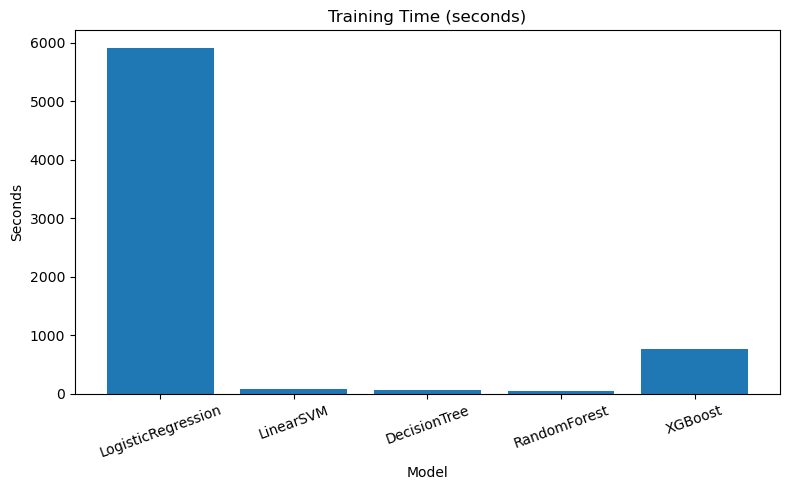

In [21]:
# -------------------------
# 7) Training Time Comparison (bar)
# -------------------------
plt.figure(figsize=(8,5))
plt.bar(list(train_times.keys()), list(train_times.values()))
plt.title("Training Time (seconds)")
plt.xlabel("Model"); plt.ylabel("Seconds")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [23]:
# -------------------------
# 8) Quick Health Checks
# -------------------------
print("Models trained:", list(preds.keys()))
assert all(np.asarray(p).shape == y_test.shape for p in preds.values())
for name, cm in conf_mats.items():
    assert cm.shape == (10, 10), f"{name} CM wrong shape"
    assert cm.sum() == len(y_test), f"{name} CM counts don't match test size"
print(" Predictions & confusion matrices look consistent.")
print("Top of summary:\n", pd.DataFrame(summary_rows).head())

Models trained: ['LogisticRegression', 'LinearSVM', 'DecisionTree', 'RandomForest', 'XGBoost']
 Predictions & confusion matrices look consistent.
Top of summary:
                 Model  Accuracy  Precision(macro)  Recall(macro)  F1(macro)  \
0  LogisticRegression  0.919286          0.918185       0.918073   0.918074   
1           LinearSVM  0.911667          0.910415       0.910392   0.910285   
2        DecisionTree  0.865524          0.863986       0.863665   0.863787   
3        RandomForest  0.966571          0.966367       0.966274   0.966300   
4             XGBoost  0.974524          0.974414       0.974302   0.974341   

   Train_Time_s  
0   5913.759011  
1     68.944656  
2     60.185183  
3     37.436820  
4    763.390813  
